# Project : Airline on-time performance (exploratory analysis)

<a id="toc"></a>

## Table of Contents

* [Introduction](#intro)
* [Preliminary Data Wrangling](#wrangling)
* [Exploratory Data Analysis](#eda)
* [Conclusions](#conclusions)

<a id="intro"></a>

[TOC](#intro)               
## Introduction

We are going to investigate flight datasets in order to gain insights on airline on-time performance from 2005 to 2008. The goal is to understand reasons that tend to make a flight delayed or cancelled. In particular, we will be intersted in the following key questions:





* Are there certain destination or arrival cities that are home to more delays or cancellations?
* What are the preferred times for flights to occur? 
* Are there any changes over multiple years?

* When is the best time of day/day of week/time of year to fly to minimise delays?
* Do older planes suffer more delays?
* How does the number of people flying between different locations change over time?
* How well does weather predict plane delays?
* Can we detect cascading failures as delays in one airport create delays in others? Are there critical links in the system?
* What are the flight patterns 

---------------------------------------
hich factors are most likely to be the root of a delays ? (computing the total delays per factor)
Is there a relationship between delay and : company ? plane ? city ? continent ?
Which factors are most likely to be the root of a delays for a given company ? for a given plane ? (computing the total delays per factor)
How does the number of passengers/seats on a flight may impact its delay ?
How does the weather report impact flights delay ? (globally ? per company ?)
Which are the company that encounter more delay ?
Which are the departure that encounter more delay ?
Does the age of the planes impact its delay ?
Which days of the week  encounter more delay ? (to be answered by origin and by destination) ; do the same thing for the months of the year
Compare the companies on-time performance over the years
Which companies computed the most CarrierDelay ?
Which cities computed the most WeatherDelay ? (globally ? per company ?)
Which companies computed the most delay ? (sum up all delays for each observation)
Explore the departure delays. (per company; per plane; per plane model; per plane age; per plane manufacturer; per city; per weither )
Is the flight distance somehow correlated to the delay ? (the longer the distance, the longer the delay ?)
How does the flights cancellation are distributed ? (over the months ? over the companies ? over the reasons ?)
How does the flights cancellation evolved ? (generally ? per company ?)

----------------------------------------------
We will explore the data while having three identities in mind:
* a passenger, who want to know before hand if he may be stuck in an airport waiting for his flight, and plan accordingly.
* an airport administrative, who want to understand issues causing delay, in order to know what he can work on so that he improve the aiport performance.
* a freight company administrative, who also want to understand issues causing delay, in order to know which aspect of his planes he should take note of so that he improve his planes performance.
                     
                     
                       

> **Report date : February 2023**     
> **Written by : [Ekoue LOGOSU-TEKO](https://www.linkedin.com/in/ekouelogosuteko/?locale=en_US)**



In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from dateutil.parser import parse
from datetime import datetime

%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


<a id="wrangling"></a>

## Preliminary Data Wrangling
[TOC](#intro)          

### General Properties                
Our main data come from 04 different datasets, each one targeting a particular year, from 2005 to 2008. We will load each of them.

In [2]:
flight_df_05 = pd.read_csv("./datasets/2005.csv")
flight_df_05.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,29,30,31,2
DayOfWeek,5,6,7,1,7
DepTime,1603.0,1559.0,1603.0,1556.0,1934.0
CRSDepTime,1605,1605,1610,1605,1900
ArrTime,1741.0,1736.0,1741.0,1726.0,2235.0
CRSArrTime,1759,1759,1805,1759,2232
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,541,541,541,542


In [3]:
flight_df_06 = pd.read_csv("./datasets/2006.csv")
flight_df_06.head().T

,0,1,2,3,4
Year,2006,2006,2006,2006,2006
Month,1,1,1,1,1
DayofMonth,11,11,11,11,11
DayOfWeek,3,3,3,3,3
DepTime,743.0,1053.0,1915.0,1753.0,824.0
CRSDepTime,745,1053,1915,1755,832
ArrTime,1024.0,1313.0,2110.0,1925.0,1015.0
CRSArrTime,1018,1318,2133,1933,1015
UniqueCarrier,US,US,US,US,US
FlightNum,343,613,617,300,765


In [4]:
flight_df_07 = pd.read_csv("./datasets/2007.csv")
flight_df_07.head().T

,0,1,2,3,4
Year,2007,2007,2007,2007,2007
Month,1,1,1,1,1
DayofMonth,1,1,1,1,1
DayOfWeek,1,1,1,1,1
DepTime,1232.0,1918.0,2206.0,1230.0,831.0
CRSDepTime,1225,1905,2130,1200,830
ArrTime,1341.0,2043.0,2334.0,1356.0,957.0
CRSArrTime,1340,2035,2300,1330,1000
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,2891,462,1229,1355,2278


In [5]:
flight_df_08 = pd.read_csv("./datasets/2008.csv")
flight_df_08.head().T

,0,1,2,3,4
Year,2008,2008,2008,2008,2008
Month,1,1,1,1,1
DayofMonth,3,3,3,3,3
DayOfWeek,4,4,4,4,4
DepTime,1343.0,1125.0,2009.0,903.0,1423.0
CRSDepTime,1325,1120,2015,855,1400
ArrTime,1451.0,1247.0,2136.0,1203.0,1726.0
CRSArrTime,1435,1245,2140,1205,1710
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,588,1343,3841,3,25


In [6]:
flight_df_05.shape

(7140596, 29)

### Structure of the dataset

We have 29 features, whose signification we obtained through a search over [the net](https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD&Yv0x=D) :
* **Year**: year (e.g. 2008)

* **Month**: 1-12 

* **DayofMonth**: 1-31

* **DayOfWeek**: 1 (Monday) - 7 (Sunday)

* **DepTime**: Actual departure time (local, hhmm).

* **CRSDepTime**: Scheduled departure time (local, hhmm).

* **ArrTime**: Actual arrival time (local, hhmm).

* **CRSArrTime**: Scheduled arrival time (local, hhmm).

* **UniqueCarrier**: Unique Carrier Code. It is the Carrier Code most recently used by a carrier. A numeric suffix is used to distinguish duplicate codes, for example, PA, PA (1), PA (2). This field is to be used to perform analysis of data reported by one and only one carrier.

* **FlightNum**: A one to four character alpha-numeric code for a particular flight.

* **TailNum**: Plane tail number; aircraft registration, unique aircraft identifier.

* **CRSElapsedTime**: Scheduled elapsed time computed from gate departure time to gate arrival time. In minutes.

* **ActualElapsedTime**: elapsed time computed from gate departure time to gate arrival time. In minutes.

* **AirTime**: The time spent by the plane in the air. In minutes.

* **ArrDelay**: Arrival delay of the flight, in minutes. Arrival delay equals the difference of the actual arrival time minus the scheduled arrival time. A flight is considered on-time when it arrives less than 15 minutes after its published arrival time.

* **DepDelay**: Departure delay of the flight, in minutes. It is the difference between the scheduled departure time and the actual departure time from the origin airport gate.

* **Origin**: Origin IATA airport code. Supposedly, this is the origin airport.

* **Dest**: Destination IATA airport code. Supposedly, this is the destination airport.

* **Distance**: The distance of the flight. In miles.


* **TaxiIn**: Taxi-in time, in minutes. The time elapsed between wheels down and arrival at the destination airport gate.

* **TaxiOut**: Taxi-out time, in minutes. The time elapsed between departure from the origin airport gate and wheels off.

* **Cancelled**: A flight that was listed in a carrier's computer reservation system during the seven calendar days prior to scheduled departure but was not operated.

* **CancellationCode**: reason for cancellation (A = carrier, B = weather, C = NAS, D = security)

* **Diverted**: 1 = yes, 0 = no. Indicate whether or not a flight was required to land at a destination other than the original scheduled destination for reasons beyond the control of the pilot/company.

* **CarrierDelay**: In minutes. Carrier delay record the delays that are within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.

* **WeatherDelay**: In minutes. Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.

* **NASDelay**: In minutes. Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.

* **SecurityDelay**: In minutes. Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

* **LateAircraftDelay** in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.
          
          

*Note* : CRS stand for Computer Reservation System. CRS provide information on airline schedules, fares and seat availability to travel agencies and allow agents to book seats and issue tickets.

A quick observation : we have our main data separated over 04 datasets, we will later fuse them together as a whole in one dataframe.

We also have complementary datasets, which give more informations about variables in the main datasets.

In [2]:
# Load freight companies data
carrier_df = pd.read_csv("./datasets/carriers.csv")
carrier_df.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [3]:
# Load planes data
plane_df = pd.read_csv("./datasets/plane-data.csv")
plane_df

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5024,N997DL,Corporation,MCDONNELL DOUGLAS AIRCRAFT CO,03/11/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992
5025,N998AT,Corporation,BOEING,01/23/2003,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002
5026,N998DL,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992
5027,N999CA,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998


In [9]:
plane_df["manufacturer"].unique()

array([nan, 'EMBRAER', 'AIRBUS INDUSTRIE', 'BOEING', 'DOUGLAS',
       'MCDONNELL DOUGLAS', 'CANADAIR', 'BOMBARDIER INC', 'AIRBUS',
       'CESSNA', 'SAAB-SCANIA', 'BEECH', 'SIKORSKY',
       'GULFSTREAM AEROSPACE', 'AEROSPATIALE', 'PIPER', 'AGUSTA SPA',
       'AERO COMMANDER', 'PAIR MIKE E', 'AVIAT AIRCRAFT INC', 'RAVEN',
       'DEHAVILLAND', 'WOBIG WAYNE R', 'BELL', 'FREDERICK CHRIS K',
       'FRIEDEMANN JON', 'STINNETT RON', 'HELIO', 'LEBLANC GLENN T',
       'MARZ BARRY', 'MORSE GEORGE JR', 'AEROSPATIALE/ALENIA',
       'BAUMAN RANDY', 'DIAMOND AIRCRAFT IND INC', 'BOEING OF CANADA LTD',
       'MCDONNELL DOUGLAS CORPORATION', 'MCDONNELL DOUGLAS AIRCRAFT CO',
       'COBB INTL/DBA ROTORWAY INTL IN', 'AERONCA', 'MAULE'], dtype=object)

In [4]:
# Load airports data
airport_df = pd.read_csv("./datasets/airports.csv")
airport_df.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


Our analysis will be focused on the features of our main datasets, while the secondary datasets are will provide additional informations when necessary (for example, provide the full name of an aiport instead of its IATA code in an plot).                 

In the main dataset, we will mainly be interested in the time-related features, while distance, delay reasons, and location related features will be used to support our main investigation.

Let's immediatly fuse the content of our main datasets.

In [11]:
# Observing the shape of the datasets from each year
flight_df_05.shape, flight_df_06.shape, flight_df_07.shape, flight_df_08.shape

((7140596, 29), (7141922, 29), (7453215, 29), (2389217, 29))

We will take note of the fact that the data of 2008 is little compared to the others years.

In [ ]:
# Fusing the datasets from each year so that our data become a whole
flight_df = pd.concat([flight_df_05,flight_df_06,flight_df_07,flight_df_08],ignore_index=True)
flight_df.shape

In [ ]:
flight_df.info()

In [ ]:
# Check N/A values count for each variable
flight_df.isna().sum()

In [ ]:
# Check null values count for each variable
flight_df.isnull().sum()

N/A check and null check are giving the same result, so there is nothing to worry about there underlying content

In [ ]:
flight_df.head().T

In [ ]:
flight_df.shape

In [ ]:
# flight_df.dropna(inplace=True)
# flight_df.shape

One thing to note is that there are some time data under one or two digit, instead of four digits. For example, `55` or `7`. Such an entry should originally be prefixed by `0`s under their string form, before having the `0`s removed when they were parsed to int. For example `0055` or `0007` which will stand for `00:05` and `00:07`.           
And example of such an entry is in the next cell. We will take note of that case so that we take the appropriate steps when working on the time related variables.

In [ ]:
flight_df.iloc[166,:]

There is another thing to take not of : `DepDelay` computed the difference in minute between `DepTime` and `CRSDepTime`; but sometimes, there are discordance between `DepDelay` and the sum of `CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay`.                            

This may be related to the fact that not all delay reasons are recorded in our dataset. An example of such case is illustrated in the next cell.

In [ ]:
# Example of flights were there are discordance between DepDelay and the sum of delay reasons
flight_df.loc[[4,5,6,7,10],["DepTime","CRSDepTime","DepDelay","CarrierDelay","WeatherDelay",
                            "NASDelay","SecurityDelay","LateAircraftDelay"]].T

In order to avoid our analyzes being contradictory, we will later create a new feature named `OtherDelay`, which will record the missing minute to make the sum of delay reasons concordant with DepDelay.

**Data Overview conclustion** :      
* We have 24124950 samples for 29 variables. 
* Dropping the null values in our main dataset let us with only 2 remaining samples. So we will focus on dropping samples which have null value related to delay variables, which will hopefully let us with a good number of data to work with.   
* New datetime variables, such as `DepDate` and `ArrDate`, should be created based on the existing date and time variables in the dataset so that our future datetime based operations are easier and cleaner.

### Data assessment and cleaning


Since our work will revolve around on-time performance, we will remove all samples whose delay observations are missing.

In [ ]:
flight_df.dropna(subset=["CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"] ,inplace=True)
flight_df.shape

In [ ]:
flight_df.dropna(subset=["ArrDelay","DepDelay"] ,inplace=True)
flight_df.shape

In [ ]:
flight_df.isna().sum()

Nearlly all information in CancellationCode is N/A. So I will drop this feature.

In [ ]:
flight_df.shape

In [ ]:
flight_df.drop(["CancellationCode"],axis=1,inplace=True)
flight_df.shape

In [ ]:
flight_df.isna().sum()

Only one plane doesn't have a tail-number in our dataset. We shall drop it.

In [ ]:
flight_df.dropna(inplace=True)
flight_df.shape

In [ ]:
flight_df.isnull().sum()

In [ ]:
# Check for duplicate values
flight_df.duplicated().sum()

In [ ]:
# Drop duplicate values
flight_df.drop_duplicates(inplace=True)

In [ ]:
# Confirm that duplicate values were removed
flight_df.duplicated().sum()

In [ ]:
flight_df["DepTime"].value_counts()

In [ ]:
# Convert DepTime variable to int (to remove decimal), then to string (to facilitate future datetime engineering)
flight_df["DepTime"] = flight_df["DepTime"].astype(int).astype(str)

In [ ]:
# Convert CRSDepTime variable to string (to facilitate future datetime engineering)
flight_df["CRSDepTime"] = flight_df["CRSDepTime"].astype(str)

In [ ]:
# Convert ArrTime variable to int (to remove decimal), then to string (to facilitate future datetime engineering)
flight_df["ArrTime"] = flight_df["ArrTime"].astype(int).astype(str)

In [ ]:
# Convert CRSArrTime variable to string (to facilitate future datetime engineering)
flight_df["CRSArrTime"] = flight_df["CRSArrTime"].astype(str)

In [ ]:
flight_df.info()

In [ ]:
# flight_df["DepTime_"] = flight_df["DepTime"][:2]+":"+flight_df["DepTime"][2:]
# flight_df.head().T

In [ ]:
# flight_df.reset_index(inplace=True)

In [ ]:
# datetime_str = "09-19-2022 13:55"
# datetime.strptime(datetime_str,"%m-%d-%Y %H:%M")

In [ ]:
time = "1305"
time[:2] + ":"+time[2:]

In [ ]:
datetime_str = "{}-{}-{} {}".format(1,21,2005,"13:05")
datetime.strptime(datetime_str,"%m-%d-%Y %H:%M") # df.loc[index,new_datetime_column] =

In [ ]:
# flight_df.query("Month=={} &  DayofMonth=={} &  Year=={} & DepTime=={}".format(1,21,2005,"1305"))

In [ ]:
# flight_df.iloc[165:167,:]

In [ ]:
flight_df.query("index==166").T

In [ ]:
flight_df.head().T

In [ ]:
# time="55"
# if len(time)<4:
#     diff = 4-len(time)
#     time = "0"*diff+time
# time

In [ ]:
def engineer_datetime_feature(df:pd.DataFrame, new_datetime_column:str, time_column:str, 
                              month_column="Month", day_column="DayofMonth", year_column:str="Year",
                              verbose=False)->pd.DataFrame:
    
    # Create new column (the column to hold the datetime data)
    df[new_datetime_column] = np.nan 
    
    print("Dataset shape : {}".format(df.shape))
    print("---------"*3)
    
    # Iterate over each sample in the dataset
    for index,row in df.iterrows(): 
        print("Processing row index : {} ".format(index))
#         print(row)
#         print("..."*2)
#         print(row["popularity"])
#         print("..."*2)
#         print(index)
#         print("---"*8)

        # Retrieve date sub-informations from the related variables
        month = row[month_column]
        day = row[day_column]
        year = row[year_column]
        
        time=row[time_column]
        # Put 0 at the start of time which lenght are < 4 (because this error should be the result of parsing the time to int)
        if len(time)<4:
            diff = 4-len(time)
            time = "0"*diff+time
        
        # Put a semi-column to format time properly
        time = "{}:{}".format(time[:2], time[2:])  
        
        
        datetime_str = "{}-{}-{} {}".format(month,day,year,time)
        df.loc[index,new_datetime_column] = datetime.strptime(datetime_str,"%m-%d-%Y %H:%M") 
    
    print("Processed all rows")
    
    return df

In [ ]:
# flight_df = engineer_datetime_feature(flight_df, new_datetime_column="DepDateTime", time_column="DepTime")
flight_df.head(3).T

We wanted to created datetime variables for each of time related variable, but the code always gives an error related to unsufficient RAM. So we will let this idea and mark it as a limitation in our work

In [9]:
saved_datasets_folder="datasets/saved"

In [10]:
# TODO : comment code in this cell before submiting the work

# Save the dataset, so that I am not required to re-run all the previous cells when I resume the work after a break
#flight_df.to_csv("{}/flight_df.csv".format(saved_datasets_folder),index=False)

In [11]:
# TODO : comment code in this cell before submiting the work
flight_df = pd.read_csv("{}/flight_df.csv".format(saved_datasets_folder))
flight_df.head(3).T

,0,1,2
Year,2005,2005,2005
Month,1,1,1
DayofMonth,28,29,30
DayOfWeek,5,6,7
DepTime,1603,1559,1603
CRSDepTime,1605,1605,1610
ArrTime,1741,1736,1741
CRSArrTime,1759,1759,1805
UniqueCarrier,UA,UA,UA
FlightNum,541,541,541


#### Assess-clean `plane_df`

In [22]:
plane_df.head()

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
plane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tailnum        5029 non-null   object
 1   type           4480 non-null   object
 2   manufacturer   4480 non-null   object
 3   issue_date     4480 non-null   object
 4   model          4480 non-null   object
 5   status         4480 non-null   object
 6   aircraft_type  4480 non-null   object
 7   engine_type    4480 non-null   object
 8   year           4480 non-null   object
dtypes: object(9)
memory usage: 353.7+ KB


`year` feature is of type string instead of int. We will clean that.

In [24]:
plane_df["year"].unique()

array([nan, '2004', '1998', '1986', '1999', '2002', '1994', '2003',
       '2005', '2006', '2000', '2001', '1997', '1995', '1996', '1987',
       '1985', 'None', '1988', '1968', '1990', '1991', '1969', '1970',
       '1992', '1993', '1965', '1989', '1959', '1980', '2008', '1983',
       '0000', '1984', '2007', '1967', '1975', '1979', '1957', '1974',
       '1978', '1963', '1956', '1972', '1962', '1973', '1982', '1976',
       '1964', '1977', '1946', '1966', '1971'], dtype=object)

We have `None` as a value of `year` feature. We will replace it by N/A.

In [25]:
# Replace 'None' by N/A
plane_df["year"] = plane_df["year"].replace(["None"],[np.nan])
plane_df["year"].unique()

array([nan, '2004', '1998', '1986', '1999', '2002', '1994', '2003',
       '2005', '2006', '2000', '2001', '1997', '1995', '1996', '1987',
       '1985', '1988', '1968', '1990', '1991', '1969', '1970', '1992',
       '1993', '1965', '1989', '1959', '1980', '2008', '1983', '0000',
       '1984', '2007', '1967', '1975', '1979', '1957', '1974', '1978',
       '1963', '1956', '1972', '1962', '1973', '1982', '1976', '1964',
       '1977', '1946', '1966', '1971'], dtype=object)

In [30]:
# Convert year from string to float (converting to int raise an error "ValueError: cannot convert float NaN to integer")
plane_df["year"] = plane_df["year"].astype(float)
plane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tailnum        5029 non-null   object 
 1   type           4480 non-null   object 
 2   manufacturer   4480 non-null   object 
 3   issue_date     4480 non-null   object 
 4   model          4480 non-null   object 
 5   status         4480 non-null   object 
 6   aircraft_type  4480 non-null   object 
 7   engine_type    4480 non-null   object 
 8   year           4335 non-null   float64
dtypes: float64(1), object(8)
memory usage: 353.7+ KB


Some of our future analyzes will be based on the age of the plane. So we will create this feature immediatly. Since we are working with dataset ranging from 2005 to 2008, we will consider the age of the plane at year 2008.

In [31]:
# Computing the age of each plane
plane_df["Age"] = 2008 - plane_df["year"]
plane_df

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,Age
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5024,N997DL,Corporation,MCDONNELL DOUGLAS AIRCRAFT CO,03/11/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992.0,16.0
5025,N998AT,Corporation,BOEING,01/23/2003,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002.0,6.0
5026,N998DL,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992.0,16.0
5027,N999CA,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998.0,10.0


In [32]:
# Confirming we have no negative age
plane_df["Age"].unique()

array([      nan, 4.000e+00, 1.000e+01, 2.200e+01, 9.000e+00, 6.000e+00,
       1.400e+01, 5.000e+00, 3.000e+00, 2.000e+00, 8.000e+00, 7.000e+00,
       1.100e+01, 1.300e+01, 1.200e+01, 2.100e+01, 2.300e+01, 2.000e+01,
       4.000e+01, 1.800e+01, 1.700e+01, 3.900e+01, 3.800e+01, 1.600e+01,
       1.500e+01, 4.300e+01, 1.900e+01, 4.900e+01, 2.800e+01, 0.000e+00,
       2.500e+01, 2.008e+03, 2.400e+01, 1.000e+00, 4.100e+01, 3.300e+01,
       2.900e+01, 5.100e+01, 3.400e+01, 3.000e+01, 4.500e+01, 5.200e+01,
       3.600e+01, 4.600e+01, 3.500e+01, 2.600e+01, 3.200e+01, 4.400e+01,
       3.100e+01, 6.200e+01, 4.200e+01, 3.700e+01])

Planes age range from 04 to 37 year old. Some planes don't have their creation year, so we can't have their age; we will keep that in mind for our future analyzes.

In [50]:
# Check N/A values
clean_plane_df.isna().sum()

tailnum          0
type             0
manufacturer     0
issue_date       0
model            0
status           0
aircraft_type    0
engine_type      0
year             0
Age              0
dtype: int64

In [45]:
plane_df.shape

(5029, 10)

In [48]:
# Remove N/A value from our plane df
clean_plane_df = plane_df.dropna()
clean_plane_df.shape

(4335, 10)

In [49]:
# Confirming we no more have any N/A value
clean_plane_df.isna().sum()

tailnum          0
type             0
manufacturer     0
issue_date       0
model            0
status           0
aircraft_type    0
engine_type      0
year             0
Age              0
dtype: int64

We will fuse our `flight_df` and `plane_df`, while making sure each plane have its complementary informations

In [51]:
flight_df.shape

(21856464, 28)

In [72]:
clean_flight_df = flight_df.merge(clean_plane_df, how="inner", left_on="TailNum", right_on="tailnum")
clean_flight_df.shape

KeyError: 'tailnum'

In [77]:
# Drop tailnum since it is useless
clean_flight_df.drop(["tailnum"],axis=1,inplace=True)
clean_flight_df.shape

(17014015, 37)

In [86]:
clean_plane_df.head()

,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,Age
34,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004.0,4.0
35,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998.0,10.0
36,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986.0,22.0
37,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999.0,9.0
38,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998.0,10.0


In [87]:
# Give a better names to our variables
clean_flight_df.rename(columns={
    "type":"PlaneType",
    "manufacturer":"PlaneManufacturer",
    "issue_date":"PlaneIssueDate",
    "model":"PlaneModel",
    "status":"PlaneStatus",
    "aircraft_type":"PlaneType",
    "engine_type":"PlaneEngine",
    "year":"PlaneCreationYear",
    "Age":"PlaneAge"
},inplace=True)
clean_flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,15,19,31,19
DayOfWeek,5,6,3,1,3
DepTime,1603,1733,807,759,1008
CRSDepTime,1605,1734,805,805,1010
ArrTime,1741,1909,912,859,1240
CRSArrTime,1759,1914,910,910,1258
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559


#### Assess-clean `carrier_df`

In [78]:
carrier_df.head(2)

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation


In [79]:
carrier_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1490 entries, 0 to 1490
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         1490 non-null   object
 1   Description  1490 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [80]:
# Drop the null value we have
carrier_df.dropna(inplace=True)
carrier_df.shape

(1490, 2)

In [60]:
# Make sure we don't have any null value anymore
carrier_df.isna().sum()

Code           0
Description    0
dtype: int64

In [81]:
clean_flight_df.shape

(17014015, 37)

In [82]:
clean_flight_df = clean_flight_df.merge(carrier_df, how="inner", left_on="UniqueCarrier", right_on="Code")
clean_flight_df.shape

(17014015, 39)

In [83]:
# Drop Code since it is useless
clean_flight_df.drop(["Code"],axis=1,inplace=True)
clean_flight_df.shape

(17014015, 38)

In [85]:
# Give a better name to variable Description
clean_flight_df.rename(columns={
    "Description":"UniqueCarrierDesc",
},inplace=True)
clean_flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,15,19,31,19
DayOfWeek,5,6,3,1,3
DepTime,1603,1733,807,759,1008
CRSDepTime,1605,1734,805,805,1010
ArrTime,1741,1909,912,859,1240
CRSArrTime,1759,1914,910,910,1258
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559


#### Assess-clean `airport_df`

In [61]:
airport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   iata     3376 non-null   object 
 1   airport  3376 non-null   object 
 2   city     3364 non-null   object 
 3   state    3364 non-null   object 
 4   country  3376 non-null   object 
 5   lat      3376 non-null   float64
 6   long     3376 non-null   float64
dtypes: float64(2), object(5)
memory usage: 184.8+ KB


In [89]:
airport_df.dropna(inplace=True)
airport_df.shape

(3364, 7)

Since, in our main dataframe, we have two variable related to airport (origin and destination), we will not fuse if `airport_df`.

In [88]:
# TODO : comment code in this cell before submiting the work

# Save the dataset, so that I am not required to re-run all the previous cells when I resume the work after a break
#clean_flight_df.to_csv("{}/clean_flight_df.csv".format(saved_datasets_folder),index=False)

In [70]:
# TODO : comment code in this cell before submiting the work
clean_flight_df = pd.read_csv("{}/clean_flight_df.csv".format(saved_datasets_folder))

In [90]:
clean_flight_df.head(3).T

,0,1,2
Year,2005,2005,2005
Month,1,1,1
DayofMonth,28,15,19
DayOfWeek,5,6,3
DepTime,1603,1733,807
CRSDepTime,1605,1734,805
ArrTime,1741,1909,912
CRSArrTime,1759,1914,910
UniqueCarrier,UA,UA,UA
FlightNum,541,557,559


<a id="eda"></a>

[TOC](#intro)               
## Exploratory Data Analysis

<a id="delay-exploration"></a>
### Exploring the departure delay distribution

We will first look at the departure delay, because it is our main variable of interest.

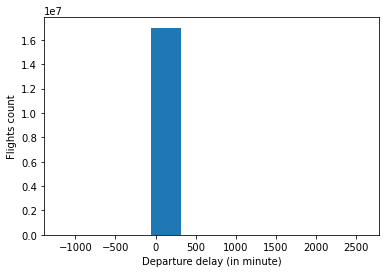

In [91]:
plt.hist(data = clean_flight_df, x="DepDelay") # plt.hist(data = flight_df, x="DepDelay")

plt.xlabel("Departure delay (in minute)")
plt.ylabel("Flights count");

The above plot is really uninformative. We will review its parameters in order to make a better plot. We will draw successive plots while improving them as we go.

In [92]:
# Observe the summary statistics of departure delay
clean_flight_df["DepDelay"].describe() # flight_df["DepDelay"].describe()

count    1.701402e+07
mean     1.124161e+01
std      3.539982e+01
min     -1.200000e+03
25%     -4.000000e+00
50%      0.000000e+00
75%      1.100000e+01
max      2.601000e+03
Name: DepDelay, dtype: float64

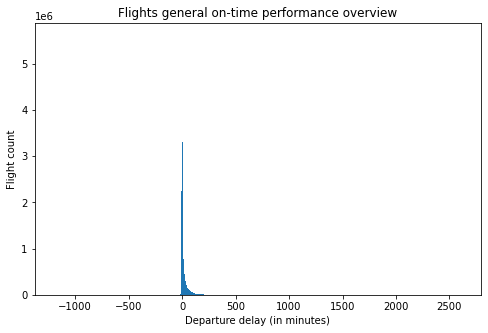

In [93]:
binsize = 5 # bin size of 5min

min_ = -1.2e3 +10
max_ = clean_flight_df["DepDelay"].max() + binsize

bins = np.arange(min_, max_, binsize)
#bins
plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

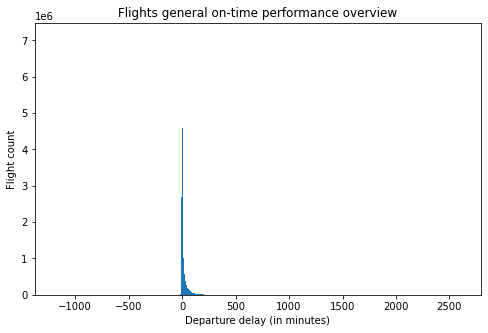

In [38]:
# binsize = 5 # bin size of 5min

# min_ = -1.2e3 +10
# max_ = flight_df["DepDelay"].max() + binsize

# bins = np.arange(min_, max_, binsize)
# #bins
# plt.figure(figsize=[8,5])
# plt.hist(data=flight_df, x="DepDelay", bins=bins)

# plt.xlabel("Departure delay (in minutes)")
# plt.ylabel("Flight count")
# plt.title("Flights general on-time performance overview");

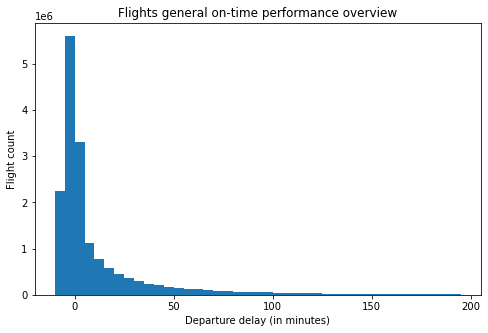

In [94]:
# Zoom-in the x-axis (to have a better view of the data)

binsize = 5 # bin size of 5 min

min_ = -10 #-1.2e3 +100
max_ = 200 #flight_df["DepDelay"].max() + binsize

bins = np.arange(min_, max_, binsize)
#bins

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

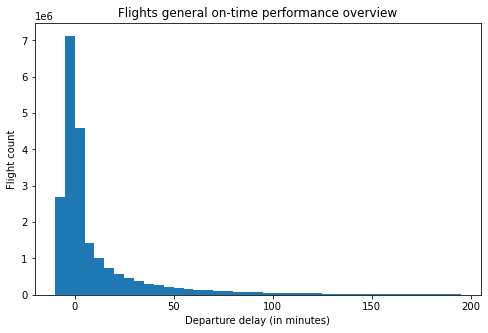

In [39]:
# # Zoom-in the x-axis (to have a better view of the data)

# binsize = 5 # bin size of 5 min

# min_ = -10 #-1.2e3 +100
# max_ = 200 #flight_df["DepDelay"].max() + binsize

# bins = np.arange(min_, max_, binsize)
# #bins

# plt.figure(figsize=[8,5])
# plt.hist(data=flight_df, x="DepDelay", bins=bins)

# plt.xlabel("Departure delay (in minutes)")
# plt.ylabel("Flight count")
# plt.title("Flights general on-time performance overview");

The data is skewed toward the right, so we will plot the distribution in a log scale instead.

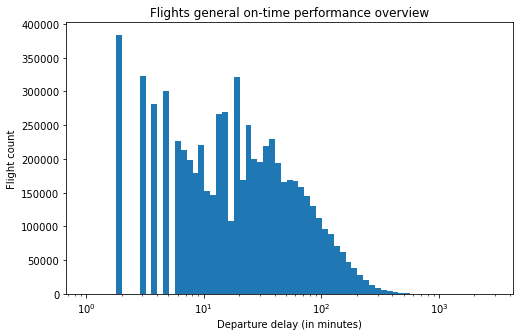

In [95]:
# Plot in the log scale

binsize = 0.05 # bin size of 30min

min_ = 0.005 #-1.2e3 +100
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

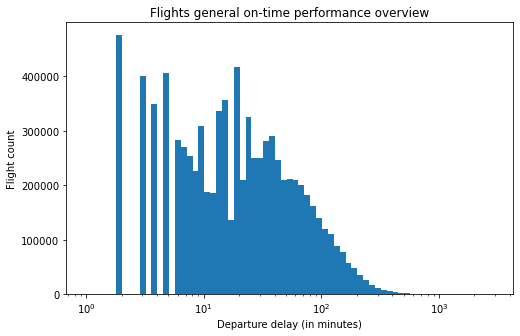

In [40]:
# # Plot in the log scale

# binsize = 0.05 # bin size of 30min

# min_ = 0.005 #-1.2e3 +100
# max_ = np.log10(flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

# bins = 10**np.arange(min_, max_, binsize)

# plt.figure(figsize=[8,5])
# plt.hist(data=flight_df, x="DepDelay", bins=bins)

# plt.xscale("log")

# plt.xlabel("Departure delay (in minutes)")
# plt.ylabel("Flight count")
# plt.title("Flights general on-time performance overview");

We have a better plot, but we will make the x-ticks label more readable.

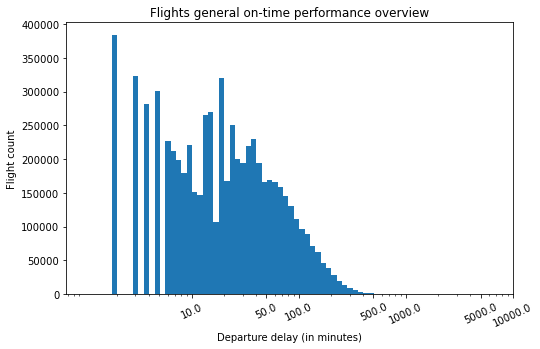

In [96]:
# Improve the x-ticks label of the "plot in the log scale"

binsize = 0.05 # bin size of 30min

min_ = 0.005 #-1.2e3 +100
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xticks([10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3], [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
          rotation=25)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

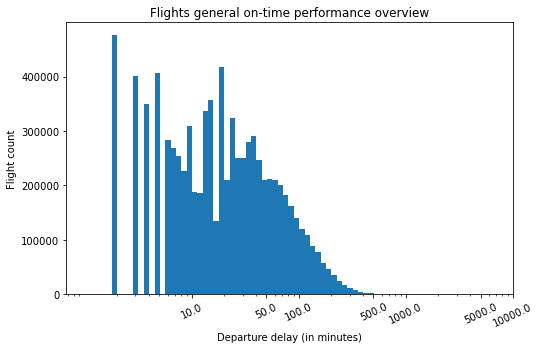

In [41]:
# # Improve the x-ticks label of the "plot in the log scale"

# binsize = 0.05 # bin size of 30min

# min_ = 0.005 #-1.2e3 +100
# max_ = np.log10(flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

# bins = 10**np.arange(min_, max_, binsize)

# plt.figure(figsize=[8,5])
# plt.hist(data=flight_df, x="DepDelay", bins=bins)

# plt.xscale("log")

# plt.xticks([10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3], [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
#           rotation=25)

# plt.xlabel("Departure delay (in minutes)")
# plt.ylabel("Flight count")
# plt.title("Flights general on-time performance overview");

Let us zoom in the relevant part of our x-axis.

In [42]:
10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3

(10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0)

<ipython-input-97-e53aeacbd3f5>:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10e2) # Zoom-in the x-axis


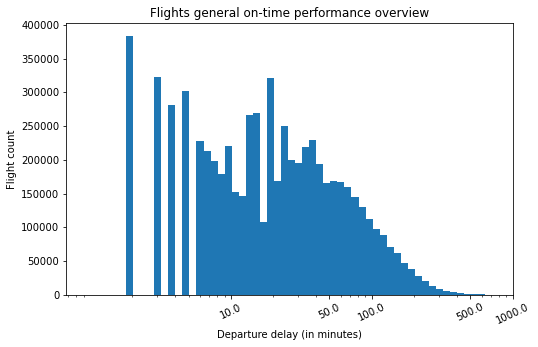

In [97]:
# Zoom-in in the x-axis

binsize = 0.05 # bin size of 30min

min_ = 0.005 #-1.2e3 +100
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xticks([10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3], [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
          rotation=25)

plt.xlim(0, 10e2) # Zoom-in the x-axis

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

Now we will add more informations in the xticks labels so that we made it easier to read.

<ipython-input-98-6be09ea910a4>:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10e2)


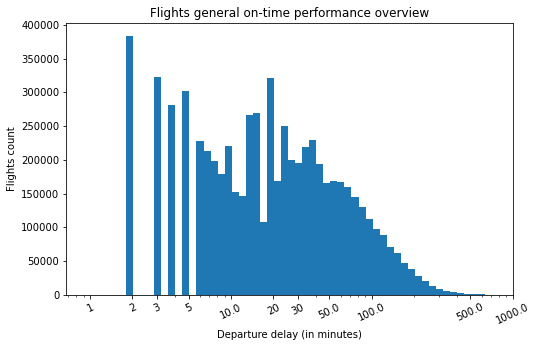

In [98]:
# Our last and perfect plot

binsize = 0.05 # bin size of 30min

min_ = 0.005 #-1.2e3 +100
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xticks([1,2,3, 10e0/2, 10e0, 20, 30, 10e1/2, 10e1,  10e2/2, 10e2,   10e3/2, 10e3], 
           [1,2,3, 5,      10.0, 20, 30, 50.0,   100.0, 500.0,  1000.0, 5000.0, 10000.0],
           rotation=25)

plt.xlim(0, 10e2)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flights count")
plt.title("Flights general on-time performance overview");

* The majority of the flights has a departure delay of 02-05 minutes, and there are a fair amount of flights which take-off after 06-20 minutes after their scheduled departure time.
* We also have a good number of flights which departure were delayed by 30-40 minutes.
* Departure delay has a long-tailed distribution in the right side. This means there are flights which has high departure delay, although they are less in number.

The standard/usual delay seems to be between 02-40 minutes. Delays over this durations are becoming less and less the further we evolve on the right side of the chart, which shows that those delays should be related to specific reasons or special cases that we will investigate later.

<a id="general-bivariate-exploration"></a>
### General bivariate exploration
First thing first. We are going to look at the pairwise correlations between features in the data.

In [99]:
clean_flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17014015 entries, 0 to 17014014
Data columns (total 38 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            int64  
 5   CRSDepTime         int64  
 6   ArrTime            int64  
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  Diverted           int64  
 23  CarrierDelay       float64
 24  WeatherDelay       float64
 25  NASDelay        

In [100]:
clean_flight_df.isna().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
PlaneType            0
PlaneManufacturer    0
issue_date           0
PlaneModel           0
PlaneStatus          0
PlaneType            0
PlaneEngine          0
PlaneCreationYear    0
PlaneAge             0
UniqueCarrierDesc    0
dtype: int64

In [103]:
# Record the variables of interest 
numeric_variables = ["Year","Month","DayofMonth","DayOfWeek","ArrDelay","DepDelay","Distance","TaxiIn","TaxiOut",
                    "CarrierDelay","WeatherDelay","NASDelay", "SecurityDelay","LateAircraftDelay","PlaneCreationYear",
                    "PlaneAge"]
categorical_variables = ["TailNum","Origin","Dest","PlaneType","PlaneManufacturer","PlaneModel","UniqueCarrierDesc",
                         "PlaneStatus","PlaneType","PlaneEngine"]

In [105]:
# Correlation between numerical features
clean_flight_df[numeric_variables].corr()

,Year,Month,DayofMonth,DayOfWeek,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,PlaneCreationYear,PlaneAge
Year,1.000000,-0.070446,-0.003141,-0.002829,0.102158,0.095445,-0.002601,-0.016417,0.045606,0.048608,0.017359,0.051756,0.004824,0.078442,0.006837,-0.006837
Month,-0.070446,1.000000,0.012174,0.009286,-0.037654,-0.032468,0.000125,-0.002559,-0.002681,-0.016920,-0.011101,-0.021307,-0.002241,-0.024692,-0.001046,0.001046
DayofMonth,-0.003141,0.012174,1.000000,-0.010347,0.014777,0.014725,0.000735,0.000540,0.003722,0.006170,0.002611,0.004710,0.001207,0.011535,-0.000445,0.000445
DayOfWeek,-0.002829,0.009286,-0.010347,1.000000,-0.005302,0.004350,0.012952,0.000697,-0.021367,0.009501,-0.001456,-0.015817,0.003557,-0.001671,0.000067,-0.000067
ArrDelay,0.102158,-0.037654,0.014777,-0.005302,1.000000,0.922881,-0.006953,0.056777,0.330635,0.557557,0.277934,0.508488,0.032448,0.603634,0.001344,-0.001344
DepDelay,0.095445,-0.032468,0.014725,0.004350,0.922881,1.000000,0.006520,0.044348,0.096911,0.592705,0.273757,0.333650,0.032608,0.638619,0.003472,-0.003472
Distance,-0.002601,0.000125,0.000735,0.012952,-0.006953,0.006520,1.000000,0.005231,0.111657,0.007554,-0.012648,0.025471,0.004015,-0.009647,0.029690,-0.029690
TaxiIn,-0.016417,-0.002559,0.000540,0.000697,0.056777,0.044348,0.005231,1.000000,0.009017,0.023059,0.073195,0.040364,0.001731,0.005823,0.002326,-0.002326
TaxiOut,0.045606,-0.002681,0.003722,-0.021367,0.330635,0.096911,0.111657,0.009017,1.000000,0.045433,0.077256,0.470991,0.006834,0.060558,0.009163,-0.009163
CarrierDelay,0.048608,-0.016920,0.006170,0.009501,0.557557,0.592705,0.007554,0.023059,0.045433,1.000000,-0.010377,0.012094,-0.003675,0.017351,-0.001386,0.001386


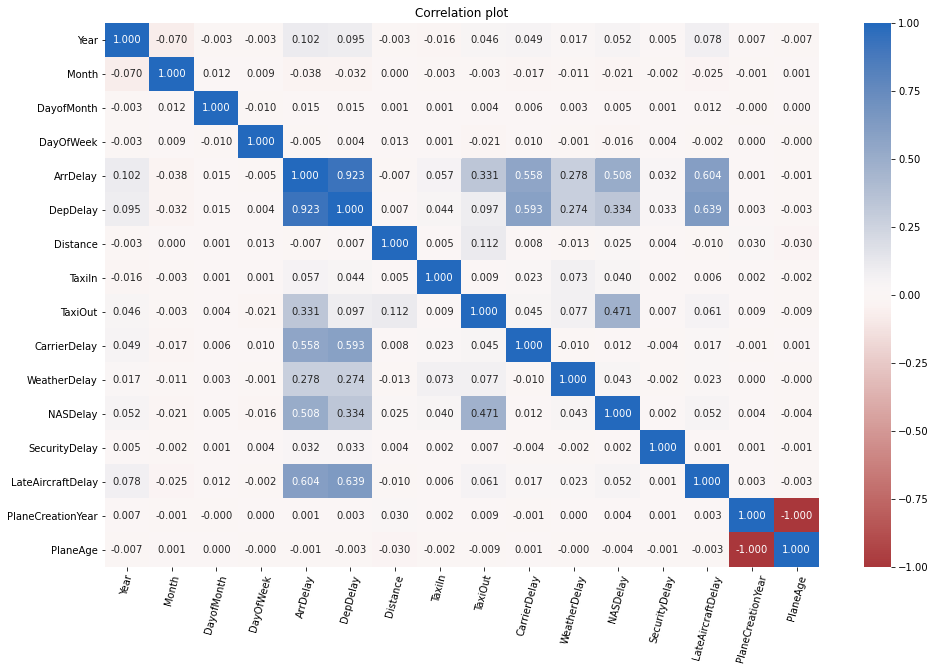

In [110]:
# Correlation plot
plt.figure(figsize = [16, 10])
sb.heatmap(clean_flight_df[numeric_variables].corr(), annot = True, fmt = '.3f',cmap = 'vlag_r', center = 0)
#plt.show()

plt.title("Correlation plot")

plt.xticks(rotation=75);

Looking at the heatmap, we have some interesting relationships between many features:
* `DepDelay` and `ArrDelay`: 0.923
* `TaxiOut` and `ArrDelay`: 0.331
* `CarrierDelay` and `ArrDelay`: 0.558
* `

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 




>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

